# Fine-tuning InceptionV3 for flowers classification

In this task you will fine-tune InceptionV3 architecture for flowers classification task.

InceptionV3 architecture (https://research.googleblog.com/2016/03/train-your-own-image-classifier-with.html):
<img src="images/inceptionv3.png" style="width:70%">

Flowers classification dataset (http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) consists of 102 flower categories commonly occurring in the United Kingdom. Each class contains between 40 and 258 images:
<img src="images/flowers.jpg" style="width:70%">

## Setup

In [1]:
! shred -u setup_google_colab.py
! wget https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py -O setup_google_colab.py

import setup_google_colab
setup_google_colab.setup_week3()

--2018-10-19 04:41:59--  https://raw.githubusercontent.com/hse-aml/intro-to-dl/master/setup_google_colab.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3595 (3.5K) [text/plain]
Saving to: ‘setup_google_colab.py’

setup_google_colab. 100%[===================>]   3.51K  --.-KB/s    in 0s      

2018-10-19 04:41:59 (40.4 MB/s) - ‘setup_google_colab.py’ saved [3595/3595]

**************************************************
102flowers.tgz
**************************************************
imagelabels.mat
**************************************************
inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
**************************************************
cifar-10-batches-py.tar.gz
**************************************************
mnist.npz


In [2]:
# use preloaded keras datasets and models
! mkdir -p ~/.keras/datasets
! mkdir -p ~/.keras/models
! ln -s $(realpath ../readonly/keras/datasets/*) ~/.keras/datasets/
! ln -s $(realpath ../readonly/keras/models/*) ~/.keras/models/

ln: failed to create symbolic link '/root/.keras/datasets/cifar-10-batches-py.tar.gz': File exists
ln: failed to create symbolic link '/root/.keras/datasets/mnist.npz': File exists
ln: failed to create symbolic link '/root/.keras/models/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5': File exists


In [0]:
import grading_utils
import grading

grader = grading.Grader(
    assignment_key="2v-uxpD7EeeMxQ6FWsz5LA", 
    all_parts=["wuwwC", "a4FK1", "qRsZ1"])

# token expires every 30 min
COURSERA_TOKEN = 'hRNLbkYHzdZhnTBy'
COURSERA_EMAIL = 'dangledangkhoa@gmail.com'

In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import display

## Dataset

Dataset was downloaded for you, it takes 12 min and 400mb.
Relevant links (just in case):
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/102flowers.tgz
- http://www.robots.ox.ac.uk/~vgg/data/flowers/102/imagelabels.mat

In [5]:
# we downloaded them for you, just link them here
! ln -s $(realpath ../readonly/week3/*) .

ln: failed to create symbolic link './102flowers.tgz': File exists
ln: failed to create symbolic link './imagelabels.mat': File exists


## Prepare images for model

In [0]:
# we will crop and resize input images to IMG_SIZE x IMG_SIZE
IMG_SIZE = 250


def decode_image_from_raw_bytes(raw_bytes):
    img = cv2.imdecode(np.asarray(bytearray(raw_bytes), dtype=np.uint8), 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

We will take a center crop from each image like this:
<img src="images/center_crop.jpg" style="width:50%">

In [7]:
import keras


def image_center_crop(img):
    """
    Makes a square center crop of an img, which is a [h, w, 3] numpy array.
    Returns [min(h, w), min(h, w), 3] output with same width and height.
    For cropping use numpy slicing.
    """
    ### YOUR CODE HERE
    h, w, c = img.shape
    a = min(h, w)
    
    h_ = slice( (h-a) // 2, (h+a) // 2, 1)
    w_ = slice( (w-a) // 2, (w+a) // 2, 1)
    cropped_img = img[h_, w_, :]
    
    return cropped_img


def prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=True):
    img = decode_image_from_raw_bytes(raw_bytes)            # decode image raw bytes to matrix
    img = image_center_crop(img)                            # take squared center crop
    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))             # resize for our model
    if normalize_for_model:
        img = img.astype("float32")                         # prepare for normalization
        img = keras.applications.inception_v3.preprocess_input(img)  # normalize for model
    return img


# reads bytes directly from tar by filename (slow, but ok for testing, takes ~6 sec)
def read_raw_from_tar(tar_fn, fn):
    with tarfile.open(tar_fn) as f:
        m = f.getmember(fn)
        return f.extractfile(m).read()

Using TensorFlow backend.


(500, 591, 3)


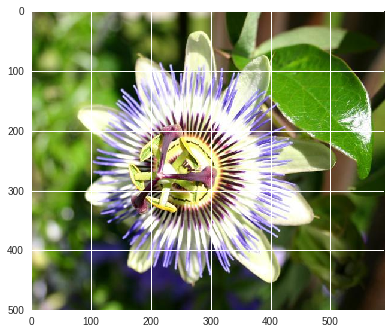

(250, 250, 3)


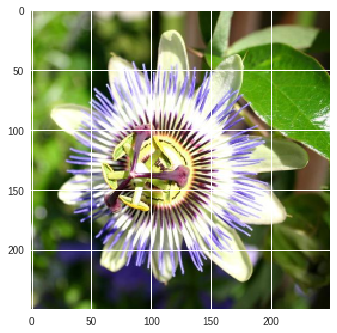

In [8]:
import tarfile
import cv2  # for image processing

# test cropping
raw_bytes = read_raw_from_tar("102flowers.tgz", "jpg/image_00001.jpg")

img = decode_image_from_raw_bytes(raw_bytes)
print(img.shape)
plt.imshow(img)
plt.show()

img = prepare_raw_bytes_for_model(raw_bytes, normalize_for_model=False)
print(img.shape)
plt.imshow(img)
plt.show()

In [9]:
## GRADED PART, DO NOT CHANGE!

# Test image preparation for model
prepared_img = prepare_raw_bytes_for_model(read_raw_from_tar("102flowers.tgz", "jpg/image_00001.jpg"))
grader.set_answer("qRsZ1", list(prepared_img.shape) + [np.mean(prepared_img), np.std(prepared_img)])

# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


## Prepare for training

In [10]:
import scipy
import scipy.io

# read all filenames and labels for them

# read filenames firectly from tar
def get_all_filenames(tar_fn):
    with tarfile.open(tar_fn) as f:
        return [m.name for m in f.getmembers() if m.isfile()]

      
all_files = sorted(get_all_filenames("102flowers.tgz"))  # list all files in tar sorted by name
all_labels = scipy.io.loadmat('imagelabels.mat')['labels'][0] - 1  # read class labels (0, 1, 2, ...)

# all_files and all_labels are aligned now
N_CLASSES = len(np.unique(all_labels))
print(N_CLASSES)

102


In [0]:
from sklearn.model_selection import train_test_split

# split into train/test
tr_files, te_files, tr_labels, te_labels = \
    train_test_split(all_files, all_labels, test_size=0.2, random_state=42, stratify=all_labels)

In [0]:
# will yield raw image bytes from tar with corresponding label
def raw_generator_with_label_from_tar(tar_fn, files, labels):
    label_by_fn = dict(zip(files, labels))
    with tarfile.open(tar_fn) as f:
        for m in f.getmembers():  # listing members is slow, but then it's fast!
            if m.name in label_by_fn:
                yield f.extractfile(m).read(), label_by_fn[m.name]

In [0]:
# batch generator
BATCH_SIZE = 32

def batch_generator(items, batch_size):
    """
    Implement batch generator that yields items by batches of size batch_size.
    Remember about the last batch that can be smaller than batch_size!
    """
    
    ### YOUR CODE HERE
    batch = [None] * batch_size
    for i, item in enumerate(items):
        batch[i%batch_size] = item
        if i%batch_size == batch_size-1:
            yield batch
            batch = [None] * batch_size
    if batch[0]:
        yield [item for item in batch if item]

In [0]:
def train_generator(files, labels):
    while True:  # so that Keras can loop through this as long as it wants
        for batch in batch_generator(raw_generator_with_label_from_tar(
                "102flowers.tgz", files, labels), BATCH_SIZE):

            # prepare batch images
            batch_imgs = []
            batch_targets = []
            for raw, label in batch:
                img = prepare_raw_bytes_for_model(raw)
                batch_imgs.append(img)
                batch_targets.append(label)

            # stack images into 4D tensor [batch_size, img_size, img_size, 3]
            batch_imgs = np.stack(batch_imgs, axis=0)

            # convert targets into 2D tensor [batch_size, num_classes]
            batch_targets = keras.utils.np_utils.to_categorical(batch_targets, N_CLASSES)
            yield batch_imgs, batch_targets

In [15]:
train_generator(tr_files, tr_labels)

<generator object train_generator at 0x7f8594ccbd58>

(32, 250, 250, 3) (32, 102)


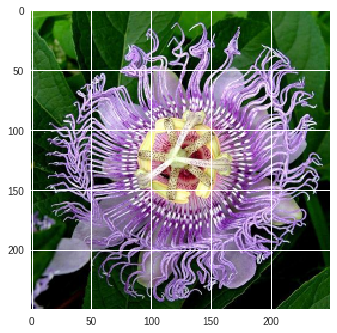

In [16]:
# test training generator

def normalize(x):
    """
    Normalize a list of sample image data in the range of 0 to 1
    : x: List of image data.  The image shape is (32, 32, 3)
    : return: Numpy array of normalized data
    """
    return np.array((x - np.min(x)) / (np.max(x) - np.min(x)))


for _ in train_generator(tr_files, tr_labels):
    print(_[0].shape, _[1].shape)
    plt.imshow(normalize(_[0][0]))
    break

In [17]:
## GRADED PART, DO NOT CHANGE!

# Test batch generator
grader.set_answer("a4FK1", list(map(lambda x: len(x), batch_generator(range(10), 3))))

# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!


## Training

You cannot train such a huge architecture from scratch with such a small dataset.

But using fine-tuning of last layers of pre-trained network you can get a pretty good classifier very quickly.

In [0]:
from keras import backend as K

# remember to clear session if you start building graph from scratch!
K.clear_session()

# don't call K.set_learning_phase() !!! (otherwise will enable dropout in train/test simultaneously)

In [0]:
def inception(use_imagenet=True):
    # load pre-trained model graph, don't add final layer
    model = keras.applications.InceptionV3(
        include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3),
        weights='imagenet' if use_imagenet else None)
    
    # add global pooling just like in InceptionV3
    new_output = keras.layers.GlobalAveragePooling2D()(model.output)

    # add new dense layer for our labels
    new_output = keras.layers.Dense(N_CLASSES, activation='softmax')(new_output)
    model = keras.engine.training.Model(model.inputs, new_output)

    return model

In [21]:
model = inception()

model.summary()

Instructions for updating:
keep_dims is deprecated, use keepdims instead
____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_1 (InputLayer)             (None, 250, 250, 3)   0                                            
____________________________________________________________________________________________________
conv2d_1 (Conv2D)                (None, 124, 124, 32)  864         input_1[0][0]                    
____________________________________________________________________________________________________
batch_normalization_1 (BatchNorm (None, 124, 124, 32)  96          conv2d_1[0][0]                   
____________________________________________________________________________________________________
activation_1 (Activation)        (None, 124, 124, 32)  0           batch_normalization_1[0][0]      
__________________

In [22]:
# how many layers our model has
print(len(model.layers))

# set all layers trainable by default and prepare batch norm for fine-tuning
for layer in model.layers:
    layer.trainable = True
    if isinstance(layer, keras.layers.BatchNormalization):
        # we do aggressive exponential smoothing of batch norm 
        # parameters to faster adjust to our new dataset
        layer.momentum = 0.8
    
# fix deep layers (fine-tuning only last 50)
for layer in model.layers[:-50]:
    layer.trainable = False

313


In [23]:
# compile new model
model.compile(
    loss='categorical_crossentropy',                # we train 102-way classification
    optimizer=keras.optimizers.adamax(lr=1e-2),     # we can take big lr here because we fixed first layers
    metrics=['accuracy']                            # report accuracy during training
)

Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [24]:
# fine tune for 2 epochs
history = model.fit_generator(
    train_generator(tr_files, tr_labels), 
    steps_per_epoch=len(tr_files) // BATCH_SIZE, 
    epochs=2,
    validation_data=train_generator(te_files, te_labels), 
    validation_steps=len(te_files) // BATCH_SIZE // 2,
)

Epoch 1/2
204/204 [==============================] - 100s - loss: 1.2517 - acc: 0.7221 - val_loss: 0.3694 - val_acc: 0.8938
Epoch 2/2
204/204 [==============================] - 85s - loss: 0.0986 - acc: 0.9769 - val_loss: 0.2456 - val_acc: 0.9289


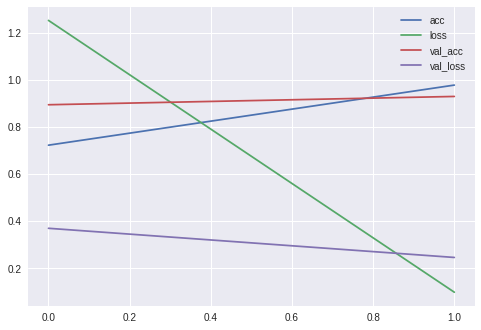

In [25]:
historydf = pd.DataFrame(history.history, index=history.epoch)
historydf.plot();

## Evaluation

In [26]:
# Accuracy on validation set
test_accuracy = model.evaluate_generator(
    train_generator(te_files, te_labels), 
    len(te_files) // BATCH_SIZE // 2
)[1]

print(test_accuracy)

0.93875


In [27]:
## GRADED PART, DO NOT CHANGE!

# Accuracy on validation set
grader.set_answer("wuwwC", test_accuracy)

# you can make submission with answers so far to check yourself at this stage
grader.submit(COURSERA_EMAIL, COURSERA_TOKEN)

Submitted to Coursera platform. See results on assignment page!
